In [6]:
# MUST AT LEAST RUN THIS ONE TO GET THE DATA VARIABLE. OTHERS ARE OPTIONAL.
%matplotlib inline
from pyspark.sql import Row
from pyspark import SparkContext
import seaborn as sns
import re
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import col,udf, unix_timestamp, abs as abs
from pyspark.sql.types import DateType
from pyspark.sql.functions import udf
from pyspark.sql.types import DataType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
import locale
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import monotonically_increasing_id
from operator import *
from pyspark.mllib.stat import Statistics
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler
import time

data = spark.read.csv('Final Project Data_Case.csv', header=True, inferSchema=True)

# define a primary key
data = data.withColumn("id", monotonically_increasing_id())
# fix column names
for column in data.columns:
    new_name = column.lower().replace(' ','_')
    data = data.withColumnRenamed(column, new_name)
    if type(data.schema[new_name].dataType) is IntegerType:
        data = data.withColumn(new_name, data[new_name].cast(DoubleType()))          
data.persist(pyspark.StorageLevel.MEMORY_ONLY)


DataFrame[age: double, female: double, flu_season: double, ed_admit: double, severity_score: double, comorbidity_score: double, readmit30: double, id: bigint]

In [4]:
x = data.describe()
x = x.withColumn('age', x.age.substr(0,5))
x = x.withColumn('female', x.female.substr(0,5))
x = x.withColumn('flu_season', x.flu_season.substr(0,5))
x = x.withColumn('ed_admit', x.ed_admit.substr(0,5))
x = x.withColumn('severity_score', x['severity_score'].substr(0,5))
x = x.withColumn('comorbidity_score', x['comorbidity_score'].substr(0,5))
x = x.withColumn('readmit30', x['readmit30'].substr(0,5))
x.show()

+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+
|summary|  age|female|flu_season|ed_admit|severity_score|comorbidity_score|readmit30|                id|
+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+
|  count| 4382|  4382|      4382|    4382|          4382|             4382|     4382|              4382|
|   mean|76.84| 0.469|     0.408|   0.809|         22.35|            94.73|    0.227|            2190.5|
| stddev|7.904| 0.499|     0.491|   0.392|         18.00|            57.14|    0.419|1265.1187691280215|
|    min| 65.0|   0.0|       0.0|     0.0|           1.0|              1.0|      0.0|                 0|
|    max|105.0|   1.0|       1.0|     1.0|         112.0|            322.0|      1.0|              4381|
+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+



In [5]:
# sns.pairplot(data.toPandas())

# Distributions overall

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bc17dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11937c128>]], dtype=object)

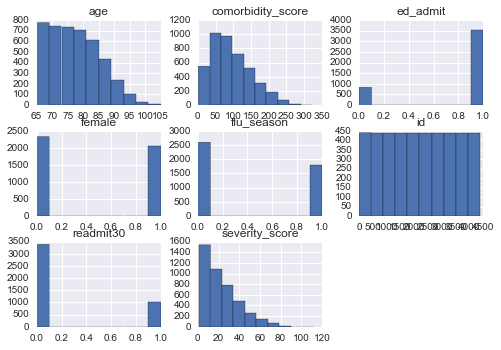

In [6]:
x = data.toPandas()
x.hist()

Distributions
Age - as expected
Cormoribidity score - as expected.
ed admit - shows our problem
female - males are disportionatly represented according to population distribution
flu_season - exceptionally high given that it is 4 months of the year
severity score - good difference in distribution


"Women make up a significant majority of the older population; the female share increases with age." Figure 28 shows that there are 58 males for every 100 females at 80 yrs old.
http://www.un.org/esa/population/publications/worldageing19502050/pdf/90chapteriv.pdf

graph of flu season
https://www.cdc.gov/flu/about/season/flu-season.htm


In [7]:
x = data.describe()
x = x.withColumn('age', x.age.substr(0,5))
x = x.withColumn('female', x.female.substr(0,5))
x = x.withColumn('flu_season', x.flu_season.substr(0,5))
x = x.withColumn('ed_admit', x.ed_admit.substr(0,5))
x = x.withColumn('severity_score', x['severity_score'].substr(0,5))
x = x.withColumn('comorbidity_score', x['comorbidity_score'].substr(0,5))
x = x.withColumn('readmit30', x['readmit30'].substr(0,5))
x.show()

+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+
|summary|  age|female|flu_season|ed_admit|severity_score|comorbidity_score|readmit30|                id|
+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+
|  count| 4382|  4382|      4382|    4382|          4382|             4382|     4382|              4382|
|   mean|76.84| 0.469|     0.408|   0.809|         22.35|            94.73|    0.227|            2190.5|
| stddev|7.904| 0.499|     0.491|   0.392|         18.00|            57.14|    0.419|1265.1187691280215|
|    min| 65.0|   0.0|       0.0|     0.0|           1.0|              1.0|      0.0|                 0|
|    max|105.0|   1.0|       1.0|     1.0|         112.0|            322.0|      1.0|              4381|
+-------+-----+------+----------+--------+--------------+-----------------+---------+------------------+



# Distributions for not readmitted patients 

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30,id
count,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.0,3384.000000
mean,76.407506,0.457742,0.375591,0.797577,19.899823,82.849586,0.0,2188.880024
std,7.791228,0.498285,0.484347,0.401865,16.388527,50.307104,0.0,1267.202072
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000
25%,70.000000,0.000000,0.000000,1.000000,6.000000,46.000000,0.0,1088.750000
50%,76.000000,0.000000,0.000000,1.000000,17.000000,75.000000,0.0,2183.500000
75%,82.000000,1.000000,1.000000,1.000000,29.000000,114.000000,0.0,3293.250000
max,105.000000,1.000000,1.000000,1.000000,100.000000,309.000000,0.0,4381.000000


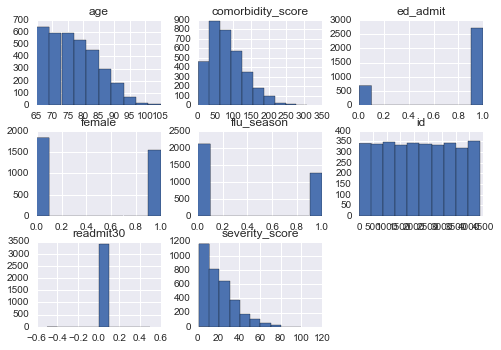

In [8]:
x = data.where(data.readmit30 == 0).toPandas()
x.hist()
x.describe()

# Distributions for readmitted patients

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30,id
count,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.0,998.000000
mean,78.338677,0.508016,0.518036,0.848697,30.672345,135.038076,1.0,2195.992986
std,8.107077,0.500186,0.499925,0.358523,20.579027,60.469747,0.0,1258.646377
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,1.000000
25%,72.000000,0.000000,0.000000,1.000000,16.000000,87.000000,1.0,1134.750000
50%,78.000000,1.000000,1.000000,1.000000,28.000000,134.000000,1.0,2209.000000
75%,84.000000,1.000000,1.000000,1.000000,44.000000,178.000000,1.0,3266.000000
max,102.000000,1.000000,1.000000,1.000000,112.000000,322.000000,1.0,4373.000000


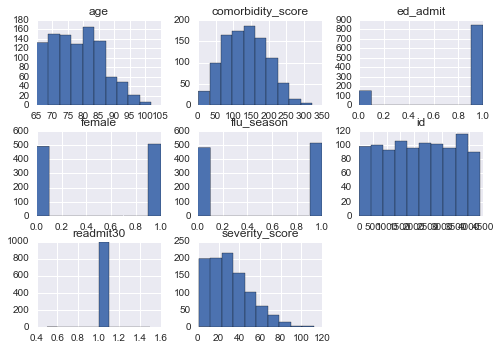

In [9]:
x = data.where(data.readmit30 == 1).toPandas()
x.hist()
x.describe()

# Distribution of not readmitted vs readmitted

In [10]:
def reassignSchema(df):
    for n,column in enumerate(data.schema):
        q = df[column.name]
        #print(q.column.name)
        df = df.withColumn(column.name, q.cast(column.dataType))
    #define a primary key
    df = df.withColumn("id", monotonically_increasing_id())
    return df
def subtractRow1ByRow2(row1, row2):
    #Row.fromSeq(s.split(",").zipWithIndex.collect{case (a,b) if n.contains(b) => a}.toSeq)
    r = Row()
    for key in row1:
        r[key] = '1'
    return Row(*r)
x = data.where(data.readmit30 == 0).describe()
y = data.where(data.readmit30 == 1).describe()
x = reassignSchema(x) # describe converts all columns to string, undo that
y = reassignSchema(y) # describe converts all columns to string, undo that
z = x.join(y, on=x.id ==y.id).select(x.summary, (x.age-y.age).alias('age'), \
                                     (x.female-y.female.alias('female') ), \
                                     (x.flu_season - y.flu_season).alias('flu_season'), \
                                     (x.ed_admit - y.ed_admit).alias('ed_admit'), \
                                     (x.severity_score - y.severity_score).alias("severity_score"), \
                                     (x.comorbidity_score - y.comorbidity_score).alias('comorbidity_score'), \
                                     (x.readmit30 - y.readmit30).alias('readmit30'))
#TODO abs
#should use doubles not int
z = z.toDF('summary','age','female', 'flu_season', 'ed_admit', 'severity_score', 'comorbidity_score', 'readmit30')
z = z.selectExpr('summary','round(abs(age),2) as age','round(abs(female),4) as female', 'round(abs(flu_season),4) as flu_season', 'round(abs(ed_admit), 4) as ed_admit', 'round(abs(severity_score),2) as severity_score', 'round(abs(comorbidity_score),2) as comorbidity_score', 'round(abs(readmit30),2) as readmit30')
#difference = z
#print('not readmitted')
#x.show()
#print('readmitted')
#y.show()
print('difference between readmitted and not readmitted')
z.show()

difference between readmitted and not readmitted
+-------+------+------+----------+--------+--------------+-----------------+---------+
|summary|   age|female|flu_season|ed_admit|severity_score|comorbidity_score|readmit30|
+-------+------+------+----------+--------+--------------+-----------------+---------+
|  count|2386.0|2386.0|    2386.0|  2386.0|        2386.0|           2386.0|   2386.0|
|   mean|  1.93|0.0503|    0.1424|  0.0511|         10.77|            52.19|      1.0|
| stddev|  0.32|0.0019|    0.0156|  0.0433|          4.19|            10.16|      0.0|
|    min|   0.0|   0.0|       0.0|     0.0|           0.0|              0.0|      1.0|
|    max|   3.0|   0.0|       0.0|     0.0|          12.0|             13.0|      1.0|
+-------+------+------+----------+--------+--------------+-----------------+---------+



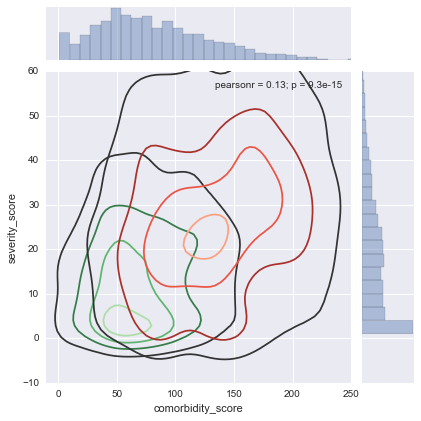

In [11]:
# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = pd.DataFrame(data.where(data.readmit30==0).toPandas(), columns=['comorbidity_score', 'severity_score'])
df2 = pd.DataFrame(data.where(data.readmit30==1).toPandas(), columns=['comorbidity_score', 'severity_score'])


# plot
# ========================================   
graph = sns.jointplot(x=df1.comorbidity_score, y=df1.severity_score, marker='', xlim=[-10,250], ylim=[-10,60])
graph.plot_joint(sns.kdeplot, zorder=5, n_levels=4, cmap="Greens_d")
graph.x = df2.comorbidity_score
graph.y = df2.severity_score
x = (graph.plot_joint(plt.scatter, marker=''))
x.plot_joint(sns.kdeplot, zorder=5, cmap="Reds_d", n_levels=4)


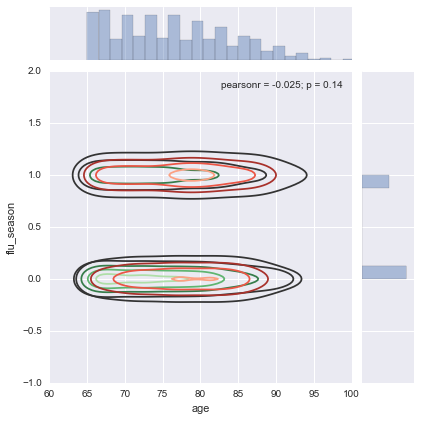

In [12]:
# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = pd.DataFrame(data.where(data.readmit30==0).toPandas(), columns=['age', 'flu_season'])
df2 = pd.DataFrame(data.where(data.readmit30==1).toPandas(), columns=['age', 'flu_season'])


# plot
# ========================================   
graph = sns.jointplot(x=df1.age, y=df1.flu_season, marker='', xlim=[60,100], ylim=[-1,2])
graph.plot_joint(sns.kdeplot, zorder=5, n_levels=4, cmap="Greens_d")
graph.x = df2.age
graph.y = df2.flu_season
x = (graph.plot_joint(plt.scatter, marker=''))
x.plot_joint(sns.kdeplot, zorder=5, cmap="Reds_d", n_levels=4)



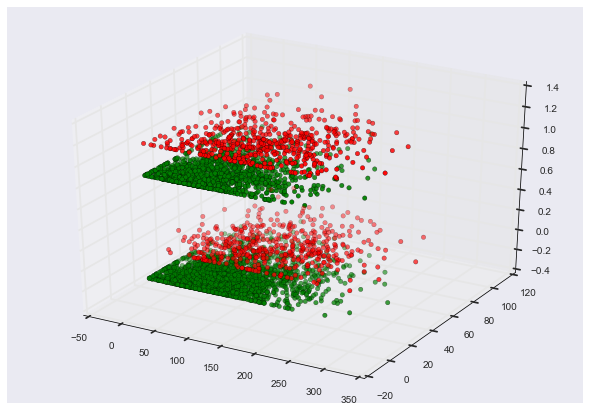

In [13]:
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D
import random

# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = pd.DataFrame(data.where(data.readmit30==0).toPandas(), columns=['comorbidity_score', 'severity_score', 'flu_season'])
df2 = pd.DataFrame(data.where(data.readmit30==1).toPandas(), columns=['comorbidity_score', 'severity_score', 'flu_season'])

fig = pylab.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = df1.comorbidity_score
sequence_containing_y_vals = df1.severity_score
sequence_containing_z_vals = df1.flu_season-.15
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c='g')

sequence_containing_x_vals = df2.comorbidity_score
sequence_containing_y_vals = df2.severity_score
sequence_containing_z_vals = df2.flu_season+.15
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c='r')

pyplot.show()



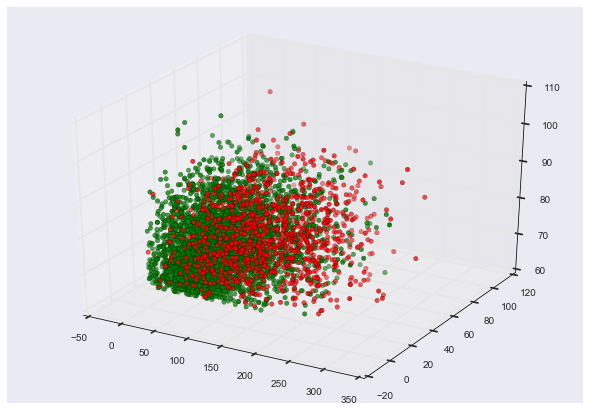

In [14]:
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D
import random

# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = pd.DataFrame(data.where(data.readmit30==0).toPandas(), columns=['comorbidity_score', 'severity_score', 'age'])
df2 = pd.DataFrame(data.where(data.readmit30==1).toPandas(), columns=['comorbidity_score', 'severity_score', 'age'])

fig = pylab.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = df1.comorbidity_score
sequence_containing_y_vals = df1.severity_score
sequence_containing_z_vals = df1.age-.15
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c='g')

sequence_containing_x_vals = df2.comorbidity_score
sequence_containing_y_vals = df2.severity_score
sequence_containing_z_vals = df2.age+.15
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c='r')

pyplot.show()




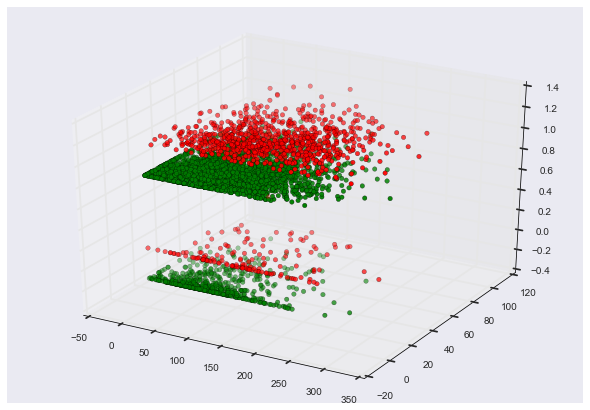

comorbidity_score    3384
severity_score       3384
ed_admit             3384
dtype: int64 comorbidity_score    998
severity_score       998
ed_admit             998
dtype: int64


In [15]:
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D
import random

# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = pd.DataFrame(data.where(data.readmit30==0).toPandas(), columns=['comorbidity_score', 'severity_score', 'ed_admit'])
df2 = pd.DataFrame(data.where(data.readmit30==1).toPandas(), columns=['comorbidity_score', 'severity_score', 'ed_admit'])

fig = pylab.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = df1.comorbidity_score
sequence_containing_y_vals = df1.severity_score
sequence_containing_z_vals = df1.ed_admit-.15
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c='g')

sequence_containing_x_vals = df2.comorbidity_score
sequence_containing_y_vals = df2.severity_score
sequence_containing_z_vals = df2.ed_admit+.15
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c='r')

pyplot.show()

print(df1.count(), df2.count())


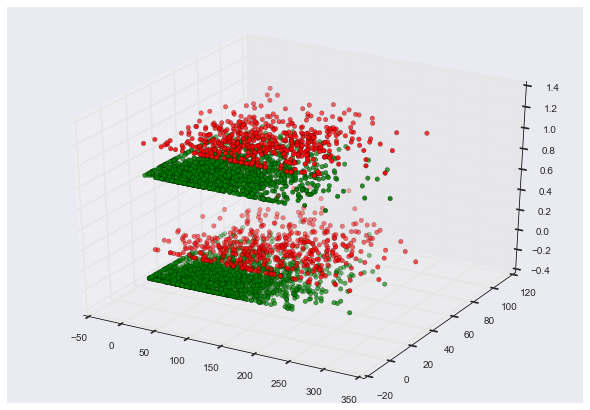

comorbidity_score    3384
severity_score       3384
female               3384
dtype: int64 comorbidity_score    998
severity_score       998
female               998
dtype: int64


In [16]:
from matplotlib import pyplot
import pylab
from mpl_toolkits.mplot3d import Axes3D
import random

# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = pd.DataFrame(data.where(data.readmit30==0).toPandas(), columns=['comorbidity_score', 'severity_score', 'female'])
df2 = pd.DataFrame(data.where(data.readmit30==1).toPandas(), columns=['comorbidity_score', 'severity_score', 'female'])

fig = pylab.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = df1.comorbidity_score
sequence_containing_y_vals = df1.severity_score
sequence_containing_z_vals = df1.female-.15
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c='g')

sequence_containing_x_vals = df2.comorbidity_score
sequence_containing_y_vals = df2.severity_score
sequence_containing_z_vals = df2.female+.15
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c='r')

pyplot.show()

print(df1.count(), df2.count())



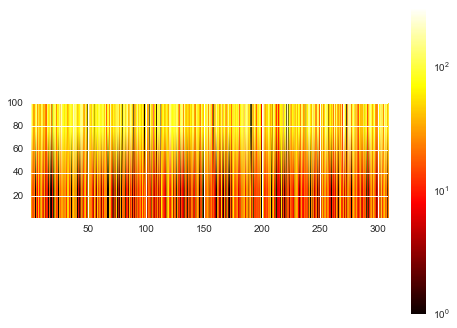

In [17]:


import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import numpy as np

# both df1 and df2 have bivaraite normals, df1.size=200, df2.size=100
df1 = pd.DataFrame(data.where(data.readmit30==0).toPandas(), columns=['comorbidity_score', 'severity_score', 'female'])
df2 = pd.DataFrame(data.where(data.readmit30==1).toPandas(), columns=['comorbidity_score', 'severity_score', 'female'])

x = df1.comorbidity_score
y = df1.severity_score
z = df1.female

plt.imshow((x,y), extent=(np.amin(x), np.amax(x), np.amin(y), np.amax(y)), cmap=cm.hot, norm=LogNorm())
plt.colorbar()
plt.show()



# Analysis

In [3]:
# correlation between...
print('severity_score & comorbidity_score', data.stat.corr('severity_score', 'comorbidity_score'))
print('severity_score & readmit30', data.stat.corr('severity_score', 'readmit30'))
print('readmit30 & comorbidity_score', data.stat.corr('readmit30', 'comorbidity_score'))

severity_score & comorbidity_score 0.1967585450865839
severity_score & readmit30 0.2509424787829938
readmit30 & comorbidity_score 0.3830477827244497


In [37]:
import gc

# Naive Bayes
best = 0
for counter in range(0, 25):
    lpData = data.rdd.map(lambda seq: LabeledPoint(seq[-2],seq[:-2]))
    train, test = lpData.randomSplit([0.7, 0.3])
    model = NaiveBayes.train(train, lambda_=0.5)
    result = test.map(lambda x: (model.predict(x.features), x.label))
    accuracy = 1.0 * result.filter(lambda x: x[0] == x[1]).count() / test.count()
    if accuracy > best : best = accuracy
    del test
    del train
    del model
    gc.collect()
print("TRAINING ACCURACY:  ", best)

TRAINING ACCURACY:   0.7363038714390066


In [7]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

testErr = .99
best = testErr
bestModel = None
while True:
    lpData = data.rdd.map(lambda seq: LabeledPoint(seq[-2],seq[:-2]))
    train, test = lpData.randomSplit([0.7, 0.3])

    # Train a GradientBoostedTrees model.
    #  Notes: (a) Empty categoricalFeaturesInfo indicates all features are continuous.
    #         (b) Use more iterations in practice.
    model = GradientBoostedTrees.trainClassifier(train, categoricalFeaturesInfo={}, numIterations=5, maxDepth=2)

    # Evaluate model on test instances and compute test error
    predictions = model.predict(test.map(lambda x: x.features))
    labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(lambda v: v[0] != v[1]).count() / float(test.count())
    if testErr<best:
        best = testErr
        bestModel = model
        print(best)
    if testErr>.19:
        train.unpersist()
        test.unpersist()
        model.unpersist()
        continue
    else:
        break
print('Test Error = ' + str(testErr))
print('Learned classification GBT model:')
print(model.toDebugString())
#labelsAndPredictions.collect()

0.21726190476190477
0.20863309352517986
0.20758928571428573
0.20263975155279504
0.19738863287250383
0.19593067068575734
0.17825443786982248
Test Error = 0.17825443786982248
Learned classification GBT model:
TreeEnsembleModel classifier with 5 trees

  Tree 0:
    If (feature 5 <= 118.0)
     If (feature 4 <= 40.0)
      Predict: -0.7643207855973814
     Else (feature 4 > 40.0)
      Predict: -0.3603238866396761
    Else (feature 5 > 118.0)
     If (feature 5 <= 167.0)
      Predict: -0.29246935201401053
     Else (feature 5 > 167.0)
      Predict: 0.13984168865435356
  Tree 1:
    If (feature 4 <= 23.0)
     If (feature 2 <= 0.0)
      Predict: -0.505512183191368
     Else (feature 2 > 0.0)
      Predict: -0.07339682765465315
    Else (feature 4 > 23.0)
     If (feature 5 <= 46.0)
      Predict: -0.36905381466556963
     Else (feature 5 > 46.0)
      Predict: 0.22244030091189912
  Tree 2:
    If (feature 2 <= 0.0)
     If (feature 4 <= 20.0)
      Predict: -0.4783783979768367
     Else

In [8]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

# Load and parse the data file.
testErr = .99
best = testErr
bestModel = None
while True:
    lpData = data.rdd.map(lambda seq: LabeledPoint(seq[-2],seq[:-2]))
    train, test = lpData.randomSplit([0.7, 0.3])

    # Train a GradientBoostedTrees model.
    #  Notes: (a) Empty categoricalFeaturesInfo indicates all features are continuous.
    #         (b) Use more iterations in practice.
    model = GradientBoostedTrees.trainRegressor(train, categoricalFeaturesInfo={}, numIterations=5, maxDepth=2)

    # Evaluate model on test instances and compute test error
    predictions = model.predict(test.map(lambda x: x.features))
    labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.map(lambda v: (v[0] - v[1]) * (v[0] - v[1])).sum() / float(test.count())
    if testErr<best:
        best = testErr
        bestModel = model
        print(best)
    if testErr>.17:
        train.unpersist()
        test.unpersist()
        continue
    else:
        break

    
print('Test Mean Squared Error = ' + str(testErr))
print('Learned regression GBT model:')
print(model.toDebugString())


0.1415783712967252
Test Mean Squared Error = 0.1415783712967252
Learned regression GBT model:
TreeEnsembleModel regressor with 5 trees

  Tree 0:
    If (feature 5 <= 124.0)
     If (feature 5 <= 63.0)
      Predict: 0.0788224121557455
     Else (feature 5 > 63.0)
      Predict: 0.20422535211267606
    Else (feature 5 > 124.0)
     If (feature 5 <= 165.0)
      Predict: 0.36752136752136755
     Else (feature 5 > 165.0)
      Predict: 0.5807291666666666
  Tree 1:
    If (feature 4 <= 32.0)
     If (feature 2 <= 0.0)
      Predict: -0.16427959006240953
     Else (feature 2 > 0.0)
      Predict: 0.05627689602430113
    Else (feature 4 > 32.0)
     If (feature 4 <= 54.0)
      Predict: 0.1581324767838928
     Else (feature 4 > 54.0)
      Predict: 0.4587380645089795
  Tree 2:
    If (feature 4 <= 23.0)
     If (feature 2 <= 0.0)
      Predict: -0.1607818709658011
     Else (feature 2 > 0.0)
      Predict: 0.009661872787431832
    Else (feature 4 > 23.0)
     If (feature 2 <= 0.0)
      Pre

In [11]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

# Load and parse the data file.
testErr = .99
best = testErr
bestModel = None
while True:
    lpData = data.rdd.map(lambda seq: LabeledPoint(seq[-2],seq[:-2]))
    train, test = lpData.randomSplit([0.7, 0.3])

    # Train a GradientBoostedTrees model.
    #  Notes: (a) Empty categoricalFeaturesInfo indicates all features are continuous.
    #         (b) Use more iterations in practice.
    model = GradientBoostedTrees.trainRegressor(train, categoricalFeaturesInfo={}, numIterations=5, maxDepth=2)

    # Evaluate model on test instances and compute test error
    predictions = model.predict(test.map(lambda x: x.features))
    labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.map(lambda v: (v[0] - v[1]) * (v[0] - v[1])).sum() / float(test.count())
    if testErr<best:
        best = testErr
        bestModel = model
        print(best)
    if testErr>.135:
        train.unpersist()
        test.unpersist()
        continue
    else:
        break
    
print('Test Mean Squared Error = ' + str(testErr))
print('Learned regression GBT model:')
print(model.toDebugString())


0.14755683968008348
0.13753652005176326
0.1370718952604701
0.135541969483806
0.13505953445518076
0.1346301610580311
Test Mean Squared Error = 0.1346301610580311
Learned regression GBT model:
TreeEnsembleModel regressor with 5 trees

  Tree 0:
    If (feature 5 <= 118.0)
     If (feature 4 <= 32.0)
      Predict: 0.11499703615886188
     Else (feature 4 > 32.0)
      Predict: 0.25059665871121717
    Else (feature 5 > 118.0)
     If (feature 5 <= 165.0)
      Predict: 0.3485915492957746
     Else (feature 5 > 165.0)
      Predict: 0.5598958333333334
  Tree 1:
    If (feature 2 <= 0.0)
     If (feature 4 <= 20.0)
      Predict: -0.1607605662724106
     Else (feature 4 > 20.0)
      Predict: 0.001994662925043192
    Else (feature 2 > 0.0)
     If (feature 5 <= 77.0)
      Predict: -0.02565367104751489
     Else (feature 5 > 77.0)
      Predict: 0.22517186597113917
  Tree 2:
    If (feature 2 <= 0.0)
     If (feature 4 <= 54.0)
      Predict: -0.08605190230107226
     Else (feature 4 > 54.0

In [15]:
model.save(sc, "myBestGradientBoostedTreesRegressionModel-" + str(testErr))

In [223]:
data

DataFrame[age: double, female: double, flu_season: double, ed_admit: double, severity_score: double, comorbidity_score: double, readmit30: double, id: bigint]

In [203]:
best

0.7571214392803598

In [224]:
(data.collect()[-2],data.collect()[:-2])


(Row(age=67.0, female=1.0, flu_season=1.0, ed_admit=1.0, severity_score=10.0, comorbidity_score=73.0, readmit30=0.0, id=4380),
 [Row(age=100.0, female=1.0, flu_season=1.0, ed_admit=1.0, severity_score=38.0, comorbidity_score=112.0, readmit30=0.0, id=0),
  Row(age=83.0, female=1.0, flu_season=0.0, ed_admit=1.0, severity_score=8.0, comorbidity_score=109.0, readmit30=1.0, id=1),
  Row(age=74.0, female=0.0, flu_season=1.0, ed_admit=0.0, severity_score=1.0, comorbidity_score=80.0, readmit30=0.0, id=2),
  Row(age=66.0, female=1.0, flu_season=1.0, ed_admit=1.0, severity_score=25.0, comorbidity_score=4.0, readmit30=0.0, id=3),
  Row(age=68.0, female=1.0, flu_season=1.0, ed_admit=1.0, severity_score=25.0, comorbidity_score=32.0, readmit30=0.0, id=4),
  Row(age=80.0, female=1.0, flu_season=0.0, ed_admit=1.0, severity_score=29.0, comorbidity_score=172.0, readmit30=0.0, id=5),
  Row(age=71.0, female=1.0, flu_season=0.0, ed_admit=1.0, severity_score=31.0, comorbidity_score=271.0, readmit30=1.0, id=